In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [2]:
# global constants
Sv=1.e9 # m^3/sec

In [3]:
# stationary forcing 
input_data = np.load('data/input_sal_temp_sine.npy')[:, 1:]
output_data = np.load('data/output_sal_temp_sine.npy')

In [4]:
X_train = input_data[0:60000]
y_train = output_data[0:60000]
X_val = input_data[60000:80000]
y_val = output_data[60000:80000]
X_test = input_data[80000:100000]
y_test = output_data[80000:100000] 

In [18]:
input_data[60000]

276.5175978542092

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

# Y_train = keras.utils.to_categorical(y_train)
# Y_val = keras.utils.to_categorical(y_val)
# Y_test = keras.utils.to_categorical(y_test)
# output_scaled = keras.utils.to_categorical(output_data)

In [9]:
# used ChatGPT here 

import numpy as np

def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 10

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [11]:
time_steps = 10  # Number of sequential vectors
feature_dim = 4  # Each vector has 5 features
batch_size = 32  # Batch size

model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model_eval = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), 
          epochs=10, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.2167 - accuracy: 0.9982 - val_loss: 0.1311 - val_accuracy: 0.9999
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0692 - accuracy: 0.9996 - val_loss: 0.0492 - val_accuracy: 0.9997
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0278 - accuracy: 0.9997 - val_loss: 0.0208 - val_accuracy: 0.9998
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0124 - accuracy: 0.9997 - val_loss: 0.0094 - val_accuracy: 0.9999
Epoch 5/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0059 - accuracy: 0.9997 - val_loss: 0.0047 - val_accuracy: 0.9997
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy:

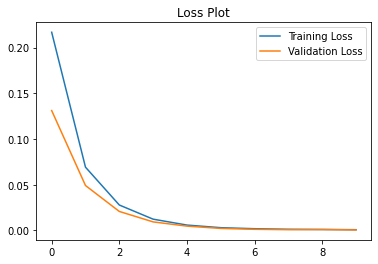

In [12]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [8]:
qplot = np.load('data/q_sal_temp_sine.npy')
time = np.load('data/input_sal_temp_sine.npy')[:, 0]

In [19]:
time[60000]

90.0

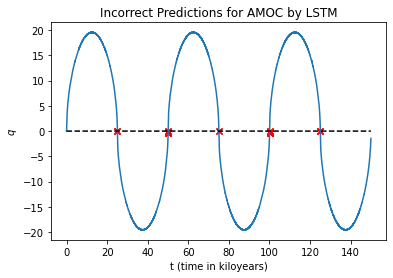

In [102]:
plt.plot(time, qplot/Sv);
plt.plot(time, input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC by LSTM');
plt.scatter([time[i] for i in false_indices_sal_temp_sine], [qplot[i]/Sv for i in false_indices_sal_temp_sine], marker='x', c='red');

In [34]:
training_losses = np.zeros(10, dtype=np.ndarray)
validation_losses = np.zeros(10, dtype=np.ndarray)

In [122]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model_eval = model.fit(X_train_seq, y_train_seq,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    os.makedirs("models_lstm_s", exist_ok=True)
    model.save('models_lstm_s/ensemble_member_'+str(i)+'.keras')

0
1
2
3
4
5
6
7
8
9


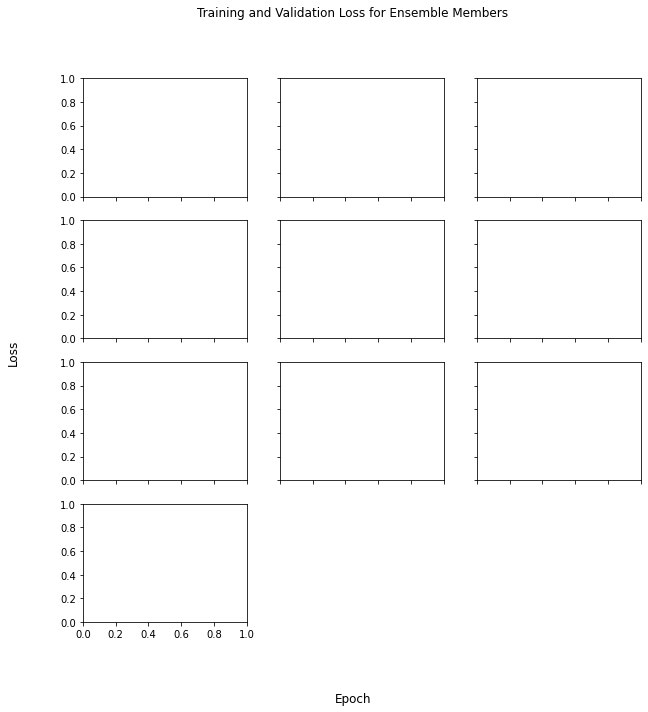

In [123]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members');
ax = ax.flatten();
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off');

In [78]:
np.save('training_loss', training_losses)

In [79]:
np.save('val_loss', validation_losses)

In [80]:
print(validation_losses)

[list([0.006712810602039099, 0.0012217351468279958, 0.002931532682850957, 0.00046014110557734966, 0.000474347616545856, 0.0007741861045360565, 0.0003333132772240788, 0.0004172330955043435, 0.000458210677606985, 0.000575376208871603])
 list([0.010493442416191101, 0.0015562480548396707, 0.0013861884362995625, 0.0006695044576190412, 0.0007321895100176334, 0.000525802664924413, 0.000766341167036444, 0.0009677751222625375, 0.00035982398549094796, 0.0004398505261633545])
 list([0.01044970192015171, 0.0015448782360181212, 0.0008511671330779791, 0.0006502066389657557, 0.0009800466941669583, 0.001372132683172822, 0.0006368407630361617, 0.0003649924183264375, 0.0003493204421829432, 0.00048478675307706])
 list([0.01043042354285717, 0.0016252186615020037, 0.0011117993853986263, 0.0026732778642326593, 0.0005229043308645487, 0.0006866889889352024, 0.0003859612625092268, 0.00041404692456126213, 0.0009486428461968899, 0.00036681655910797417])
 list([0.0010731538059189916, 0.0006858913111500442, 0.0003

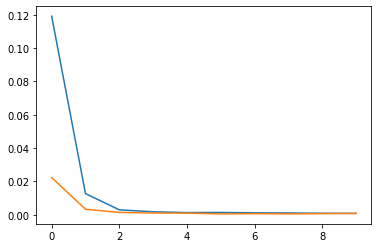

In [124]:
plt.plot(training_losses[8])
plt.plot(validation_losses[8])

In [125]:
for i in range(10):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member #' + str(i))

In [126]:
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2)  # fine-tune if needed
)

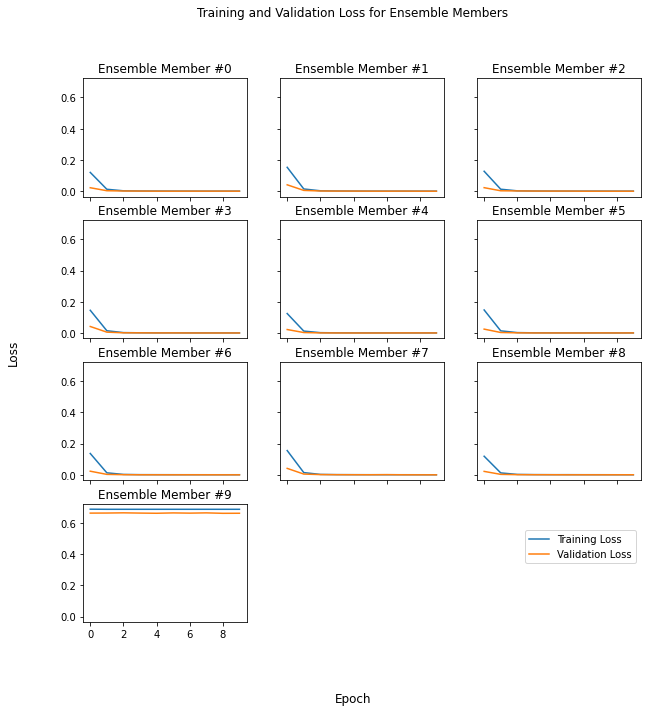

In [127]:
fig

In [128]:
fig.savefig('figures/lstm_losses_stationary', dpi=100)

In [129]:
accuracies = []

In [130]:
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_s/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_seq, y_test_seq)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
625/625 [==============================] - 1s 1ms/step - loss: 6.5144e-04 - accuracy: 0.9998
Test loss: 0.0006514366250485182
Test accuracy: 0.999799907207489
1
625/625 [==============================] - 2s 2ms/step - loss: 3.1063e-04 - accuracy: 0.9998
Test loss: 0.0003106335934717208
Test accuracy: 0.9998499155044556
2
625/625 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9997
Test loss: 0.0010900114430114627
Test accuracy: 0.9996998906135559
3
625/625 [==============================] - 1s 1ms/step - loss: 2.7550e-04 - accuracy: 0.9999
Test loss: 0.00027549819787964225
Test accuracy: 0.9999499917030334
4
625/625 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9997
Test loss: 0.001115290680900216
Test accuracy: 0.9996998906135559
5
625/625 [==============================] - 2s 1ms/step - loss: 0.0011 - accuracy: 0.9996
Test loss: 0.0011424794793128967
Test accuracy: 0.999599814414978
6
625/625 [==============================]

In [131]:
sum(accuracies)/10*100

91.66925191879272

In [11]:
feature_dim = 4

In [12]:
# predicting 

predicted_results_ensemble = np.nan * np.zeros((10, input_seq.shape[0], 1))

for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_s/ensemble_member_'+str(i)+'.keras')
    predicted = model.predict(input_seq)
    predicted_results_ensemble[i,...] = predicted

0
3125/3125 [==============================] - 4s 1ms/step
1
3125/3125 [==============================] - 4s 1ms/step
2
3125/3125 [==============================] - 3s 983us/step
3
3125/3125 [==============================] - 3s 993us/step
4
3125/3125 [==============================] - 3s 982us/step
5
3125/3125 [==============================] - 3s 977us/step
6
3125/3125 [==============================] - 4s 1ms/step
7
3125/3125 [==============================] - 3s 968us/step
8
3125/3125 [==============================] - 3s 949us/step
9
3125/3125 [==============================] - 3s 982us/step


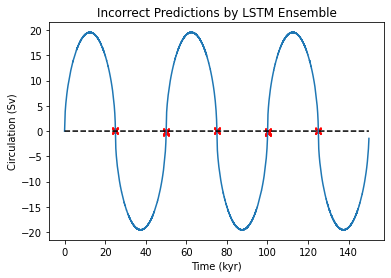

In [14]:
avg_predicted = np.mean(predicted_results_ensemble, axis=0).squeeze()
threshold = 0.5
avg_pred = (avg_predicted > threshold).astype(int)
false_indices_avg = [j for j in range(len(avg_pred)) if avg_pred[j] != output_data[j]]
fig, ax = plt.subplots()
ax.plot(time, qplot/Sv)
ax.plot(time, input_data[:, 0]*0, 'k--')
ax.set_title('Incorrect Predictions by LSTM Ensemble');
ax.set_xlabel('Time (kyr)');
ax.set_ylabel('Circulation (Sv)');
ax.scatter(
    [time[k] for k in false_indices_avg],
    [qplot[k]/Sv for k in false_indices_avg],
    marker='x', c='red', label='Errors'
)
fig.savefig('figures/lstm_predictions_s_all', dpi=100)

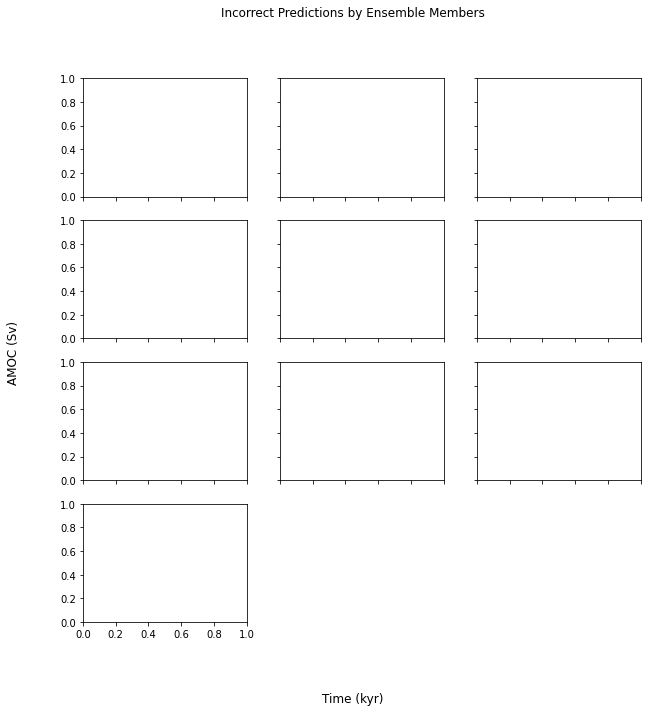

In [133]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Ensemble Members')
ax = ax.flatten()
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off')

In [134]:
for i in range(10):
    print(i)
    model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),  
    Dense(4, activation='relu'),  
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    model.load_weights('models_lstm_s/ensemble_member_' + str(i) + '.keras')
    predictions_i = (model.predict(input_seq) > threshold).astype(int)
    false_indices_i = []
    for j in range(len(predictions_i)):
        if predictions_i[j] != output_data[j]:
            false_indices_i.append(j)
    ax[i].plot(time, qplot/Sv);
    ax[i].plot(time, input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member #' + str(i));
    ax[i].scatter([time[k] for k in false_indices_i], [qplot[i]/Sv for k in false_indices_i], marker='x', c='red');

0
3125/3125 [==============================] - 4s 1ms/step
1
3125/3125 [==============================] - 6s 2ms/step
2
3125/3125 [==============================] - 6s 2ms/step
3
3125/3125 [==============================] - 4s 1ms/step
4
3125/3125 [==============================] - 6s 2ms/step
5
3125/3125 [==============================] - 5s 1ms/step
6
3125/3125 [==============================] - 4s 1ms/step
7
3125/3125 [==============================] - 4s 1ms/step
8
3125/3125 [==============================] - 4s 1ms/step
9
3125/3125 [==============================] - 4s 1ms/step


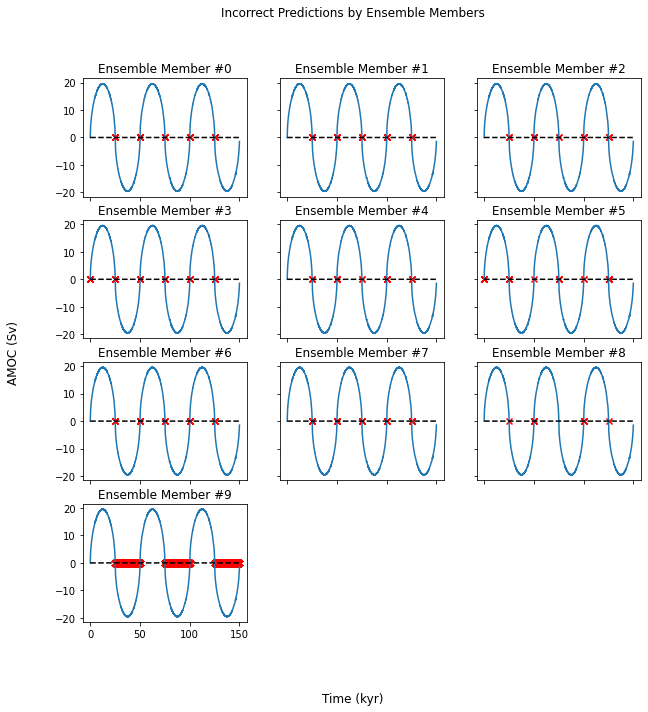

In [135]:
fig

In [136]:
fig.savefig('figures/lstm_predictions_stationary', dpi=100)